# Project 1 - SME808
* Leonardo Meireles  - NUSP: 4182085
* Antonio Moreira - NUSP: ****

## Objective
* Basic time series analysis:
    * Trend
    * Seasonality
    * Outliers
    * Structural Changes

## Properties and types of series

* **Trend** : A long-term increase or decrease in the data. This can be seen as a slope (is doesn’t have to be linear) roughly going through the data.

* **Seasonality** : A time series is said to be seasonal when it is affected by seasonal factors (hour of day, week, month, year, etc.). Seasonality can be observed with nice cyclical patterns of fixed frequency.

* **Cyclicity** : A cycle occurs when the data exhibits rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

* **Residuals** : Each time series can be decomposed in two parts:
    - A forecast, made up of one or several forecasted values
    - Residuals. They are the difference between an observation and its predicted value at each time step. 
    
Remember that: **Value of series at time t = Predicted value at time t + Residual at time t**  =: **TS(t) = P(t) + R(t)**

In [24]:
# Librarys used - All Open Source
# settings
import warnings
warnings.filterwarnings("ignore")

# Basic packages
import re
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns  # for prettier plots
import matplotlib.style as style
style.use('ggplot')
import handcalcs.render


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [20]:
def parse_co2_data(filename, columns_start_point=0):
    """
        Function that parses the NOA CO2 data to
        a more compatible format with pandas.
    """
    
    with open(filename) as f:
        file = f.readlines()[columns_start_point:]
    
    columns = re.sub(u'\s+|,,\s+', ' ', file[0]).strip().split(' ')
    df = pd.DataFrame(columns=columns)
    
    for i in range(1, len(file)):
        series = re.sub(u'\s+|,,\s+', ' ', file[i]).strip().split(' ')
        df = df.append(pd.Series(data=series, index=columns), ignore_index=True)
    
    filename = filename.replace('.csv', '_parsed.csv')
    df.to_csv(filename, index=False)    
    
    df = pd.read_csv(filename, low_memory=False)
    
    return df

## NOA CO2: Monthly CO2 Series
* Using the monthly CO2 emission time series, we are going to analyze it to find trends, seasonality, outliers and structural changes.

## Preprocessing
* The only processing we had to do was to use the interpolated value of the CO2 emission where the data was missing.
* There were no signficant outliers in the time series.

In [21]:
df_co2_mm_mlo = parse_co2_data('../data/co2_mm_mlo.csv', columns_start_point=70)
# Fill missing data with interpolated data
df_co2_mm_mlo.loc[df_co2_mm_mlo.average <= -99.99, 'average'] = df_co2_mm_mlo.loc[df_co2_mm_mlo.average <= -99.99, 'interpolated']

## Trend Analysis
* Plotting the time series and it's annual moving average and std we can try to find some kind o trend in the time series.

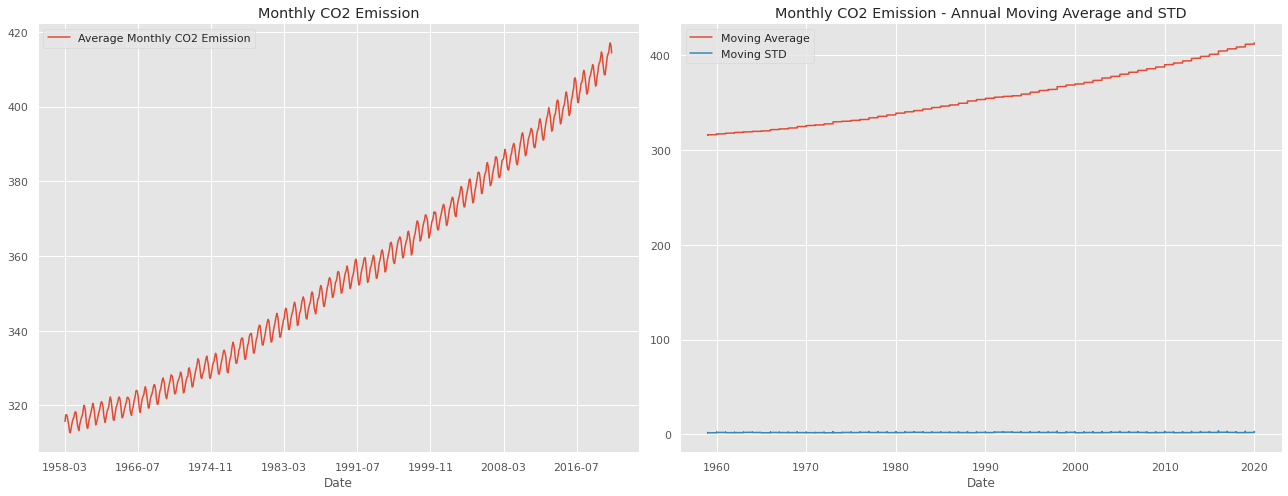

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Monthly time series
df_co2_mm_mlo['date'] = df_co2_mm_mlo['year'].map(str) + '-' + df_co2_mm_mlo['month'].map(str)
df_co2_mm_mlo['date'] = pd.to_datetime(df_co2_mm_mlo['date'], format='%Y-%m').dt.strftime('%Y-%m')

df_co2_mm_mlo.plot(x='date', y='average', ax=ax1, label='Average Monthly CO2 Emission')

# Annual moving averages period = 12 months
ax2.plot(df_co2_mm_mlo['year'],df_co2_mm_mlo['average'].rolling(window=12, center=False).mean(), label='Moving Average')
ax2.plot(df_co2_mm_mlo['year'], df_co2_mm_mlo['average'].rolling(window=12, center=False).std(), label='Moving STD')

ax1.set_title('Monthly CO2 Emission')
ax1.set(xlabel = 'Date')

ax2.set_title('Monthly CO2 Emission - Annual Moving Average and STD')
ax2.set(xlabel = 'Date')

plt.tight_layout()
plt.legend()

## Quick Observations

Looking at the moving average plot we can notice a trend that increases each year due to human advances in technology(cars, agriculture, planes) and no noticible seasonality. Also, we didn't notice any structural changes in the time series.

## Google Shares
* We are going to run the same analysis but in the time series that represents google shares from 2006 to 2018.
* Daily data containing information about Open, High, Low, Close and Volume.
* Our variable of interest in the close price:
    * A stock's closing price is the standard benchmark used by investors to track its performance over time.
    * The closing price is the last price at which the stock traded during the regular trading day.

In [61]:
# Reading the data
google = pd.read_csv(filepath_or_buffer='../data/GOOGLE_2006-01-01_to_2018-01-01.csv')

In [62]:
google.Date = pd.to_datetime(google.Date)

In [64]:
google.index = google.Date

In [65]:
# Calculating the annual moving averages and std so we and don't have to compute it everytime
annual_close_mmean = google['Close'].rolling('365D', center=False).mean()

In [66]:
annual_close_mstd = google['Close'].rolling('365D', center=False).std()

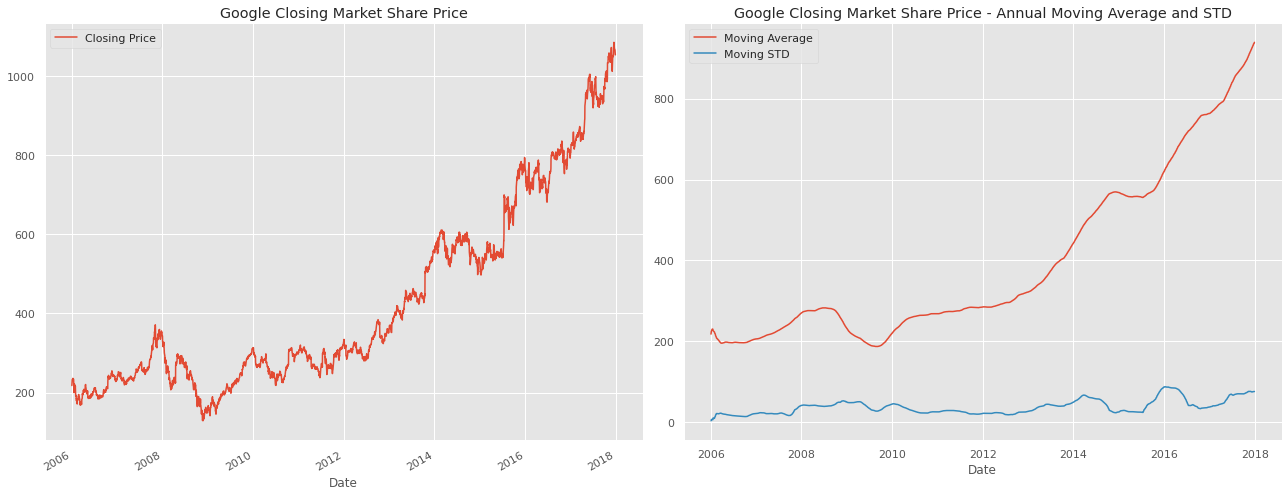

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

google.plot(x='Date', y='Close', ax=ax1, label='Closing Price')

# Annual moving averages period = 12 months
ax2.plot(google['Date'], annual_close_mmean, label='Moving Average')
ax2.plot(google['Date'], annual_close_mstd, label='Moving STD')

ax1.set_title('Google Closing Market Share Price')
ax1.set(xlabel = 'Date')

ax2.set_title('Google Closing Market Share Price - Annual Moving Average and STD')
ax2.set(xlabel = 'Date')

plt.tight_layout()
plt.legend()

## Quick Observations
Looking at the moving average plot we can notice a trend and maybe a possible seasonality, we are going to use a multiplicative version of a seasonal decomposition using stats model **sm** modulem, which tries to decompose a time series in three main components Trend, Seasonality and the Residual.

$$y = Trend*Seasonality*Residual$$

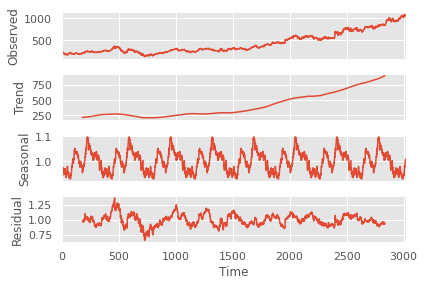

In [88]:
# Multiplicative
y = sm.tsa.seasonal_decompose(
    google['Close'].values, freq=365, model='multiplicative')

fig = y.plot()

## Final Observations on Google Dataset
* We observed trend that inscreases over the time and also and slight seasonality betwe